In [1]:
import pandas as pd
import numpy as np
import pickle as pkl

from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt

import os 
#import uproot, uproot_methods
#import uproot_methods.classes.TLorentzVector as TLorentzVector

In [25]:
#bkgFile = pd.read_hdf('/home/btannenw/Desktop/ML/anomalyDetection/lhcOlympics2020/events_LHCO2020_backgroundMC_Pythia.h5', stop=400)
#blackBox1 = pd.read_hdf('/home/btannenw/Desktop/ML/lhcOlympics2020/events_LHCO2020_BlackBox1.h5', stop=400)

topDir_hh  = '/home/btannenw/Desktop/ML/dihiggsMLProject/data/pp2hh4b_10k/'
topDir_qcd = '/home/btannenw/Desktop/ML/dihiggsMLProject/data/ppTo4b_10k/'

allEvents_hh = []
allEvents_qcd = []

for filename in os.listdir(topDir_hh):
    if filename.endswith(".pkl"):
        temp = pkl.load( open( topDir_hh+filename, 'rb' )) 
        allEvents_hh += temp
    else:
        continue
        
for filename in os.listdir(topDir_qcd):
    if filename.endswith(".pkl"):
        temp = pkl.load( open( topDir_qcd+filename, 'rb' )) 
        allEvents_qcd += temp
    else:
        continue

print( len(allEvents_hh), len(allEvents_qcd) )

25000 49978


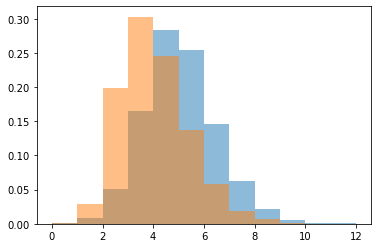

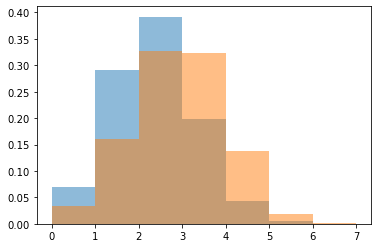

In [33]:
njets_hh = [ x['nJets'] for x in allEvents_hh]
ntags_hh = [ x['nBTags'] for x in allEvents_hh]
njets_qcd = [ x['nJets'] for x in allEvents_qcd]
ntags_qcd = [ x['nBTags'] for x in allEvents_qcd]

plt.hist( njets_hh, bins=12, range=[0,12], alpha=0.5, density=1)
plt.hist( njets_qcd, bins=12, range=[0,12], alpha=0.5, density=1)
plt.show()
plt.hist( ntags_qcd, bins=7, range=[0,7], alpha=0.5, density=1)
plt.hist( ntags_hh, bins=7, range=[0,7], alpha=0.5, density=1)
plt.show()

In [36]:
rap = [ constituent[2] for event in allEvents_hh for constituent in event['Constituents'] ]

In [51]:
def returnPhiRapidityPtLists( eventList ):
    """ return three lists of phi, rapidity, pt for later plotting """

    _rapidity_track = [ constituent[5] for event in allEvents_hh for constituent in event['Constituents'] if constituent[6]==0 ]
    _phi_track      = [ constituent[3] for event in allEvents_hh for constituent in event['Constituents'] if constituent[6]==0 ]
    _pt_track       = [ constituent[1] for event in allEvents_hh for constituent in event['Constituents'] if constituent[6]==0 ]
    _track          = [_rapidity_track, _phi_track, _pt_track]
    
    _rapidity_neutralHad = [ constituent[5] for event in allEvents_hh for constituent in event['Constituents'] if constituent[6]==1 ]
    _phi_neutralHad      = [ constituent[3] for event in allEvents_hh for constituent in event['Constituents'] if constituent[6]==1 ]
    _pt_neutralHad       = [ constituent[1] for event in allEvents_hh for constituent in event['Constituents'] if constituent[6]==1 ]
    _neutralHad          = [_rapidity_neutralHad, _phi_neutralHad, _pt_neutralHad]
    
    _rapidity_photon = [ constituent[5] for event in allEvents_hh for constituent in event['Constituents'] if constituent[6]==2 ]
    _phi_photon      = [ constituent[3] for event in allEvents_hh for constituent in event['Constituents'] if constituent[6]==2 ]
    _pt_photon       = [ constituent[1] for event in allEvents_hh for constituent in event['Constituents'] if constituent[6]==2 ]
    _photon          = [_rapidity_photon, _phi_photon, _pt_photon]
    
    
    return _track, _neutralHad, _photon


tracks_hh, neutralHadrons_hh, photons_hh = returnPhiRapidityPtLists( allEvents_hh )
tracks_qcd, neutralHadrons_qcd, photons_qcd = returnPhiRapidityPtLists( allEvents_qcd )

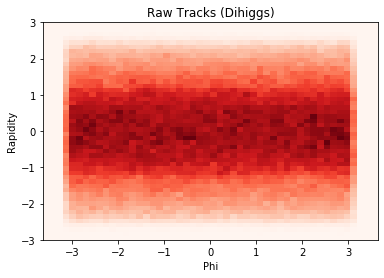

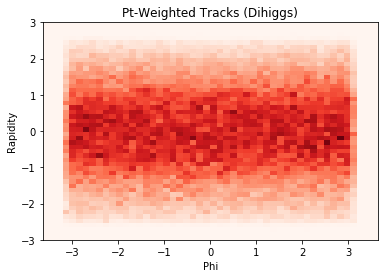

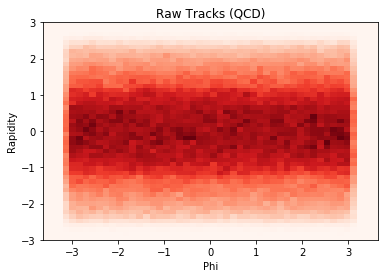

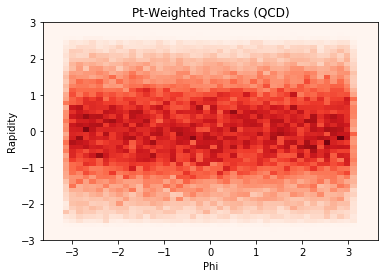

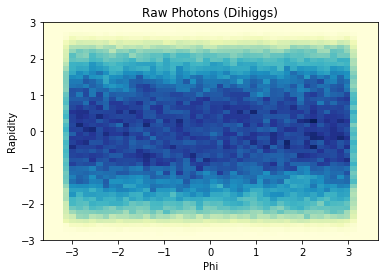

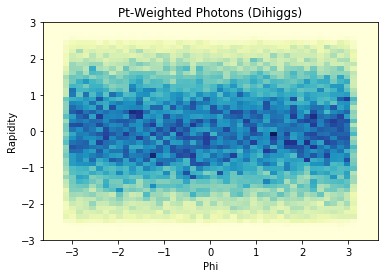

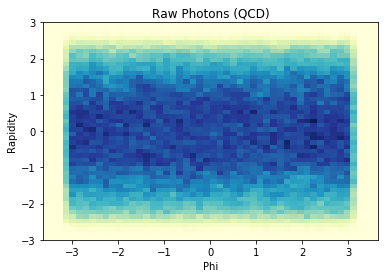

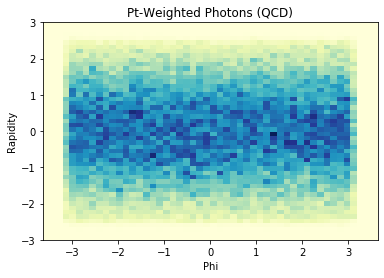

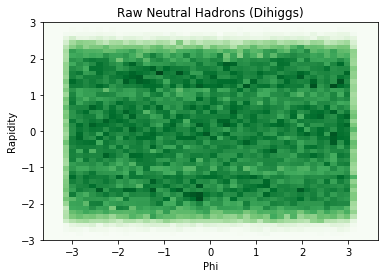

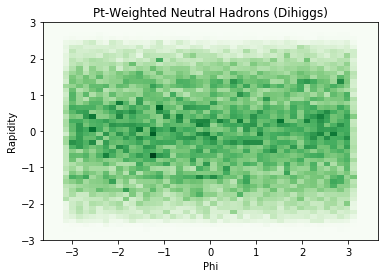

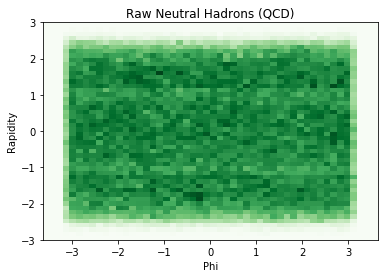

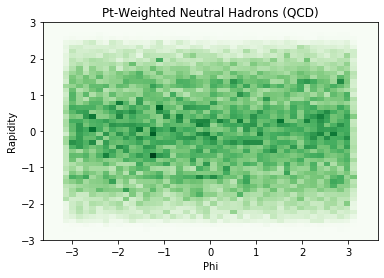

In [60]:
track_plotOpts  = dict(bins=(50, 50), range=[[-1*np.pi-0.5, np.pi+0.5],[-3.0, 3.0]], cmap=plt.cm.Reds)
photon_plotOpts = dict(bins=(50, 50), range=[[-1*np.pi-0.5, np.pi+0.5],[-3.0, 3.0]], cmap=plt.cm.YlGnBu)
nHad_plotOpts   = dict(bins=(50, 50), range=[[-1*np.pi-0.5, np.pi+0.5],[-3.0, 3.0]], cmap=plt.cm.Greens)

def makeSimplePlots( constituentList, sampleLabel='', consLabel=''):
    """ make plots"""
    
    plotOpts = {}
    if consLabel == 'Tracks':
        plotOpts = track_plotOpts
    if consLabel == 'Photons':
        plotOpts = photon_plotOpts
    if consLabel == 'Neutral Hadrons':
        plotOpts = nHad_plotOpts
    
    plt.hist2d( constituentList[1], constituentList[0], **plotOpts )
    plt.title('Raw {} ({})'.format(consLabel, sampleLabel) )
    plt.xlabel('Phi')
    plt.ylabel('Rapidity')
    plt.show()
  
    plt.hist2d( constituentList[1], constituentList[0], weights=constituentList[2], **plotOpts )
    plt.title('Pt-Weighted {} ({})'.format(consLabel, sampleLabel))
    plt.xlabel('Phi')
    plt.ylabel('Rapidity')
    plt.show()

    return


makeSimplePlots( tracks_hh, 'Dihiggs', 'Tracks')
makeSimplePlots( tracks_qcd, 'QCD', 'Tracks')

makeSimplePlots( photons_hh, 'Dihiggs', 'Photons')
makeSimplePlots( photons_qcd, 'QCD', 'Photons')

makeSimplePlots( neutralHadrons_hh, 'Dihiggs', 'Neutral Hadrons')
makeSimplePlots( neutralHadrons_qcd, 'QCD', 'Neutral Hadrons')



In [5]:
def returnTheta( _eta ):
    #return 180     - 2*np.arctan(np.exp(-1 * _eta))*360/np.pi  # degrees
    return np.pi/2 - 2*np.arctan(np.exp(-1 * _eta))            # radians

def returnEta( _theta ):
    return -1* np.log(np.tan((np.pi/2-_theta)/2))  # radians
    
def rotateEta( _eta, _theta):
    _thetaOriginal = returnTheta(_eta)
    
    print(_thetaOriginal, _theta)
    #_newTheta = (((_thetaOriginal - _theta)+np.pi) % (2*np.pi))-np.pi
    _newTheta = (((_thetaOriginal - _theta)) % (2*np.pi))
    
    return returnEta(_newTheta) 

def rotatePhi(_phi, _rotAngle):
    return (((_phi - _rotAngle)+np.pi) % (2*np.pi))-np.pi 

def getRotatedVectors( _lorentzVectors, _angle=0 , _axis=[1, 0, 0] ):
    """gets a list of lorentzVectors, an angle, and a rotation axis. spits back the rotated lorentzVectors"""
    
    _newLorentzVectors = []
    r = R.from_rotvec( _angle * np.array(_axis))   

    for _4vector in _lorentzVectors:
        _3vector = np.array([ _4vector.x, _4vector.y, _4vector.z ])
        _3vector = _3vector.dot( r.as_matrix() )
        _mag3vector = np.sqrt( np.abs( _3vector.dot(_3vector) ) )
        
        _newPt    = np.sqrt( _3vector[0]*_3vector[0] + _3vector[1]*_3vector[1] )
        _newPhi   = np.arctan2( _3vector[1], _3vector[0] )
        # z = P * cos(theta) 
        _newTheta = np.arccos( _3vector[2] / _mag3vector )
        #_newEta   = returnEta( _newTheta )
        _newEta   = -1* np.log(np.tan( (_newTheta)/2) )
        _newMass2 = np.sqrt( _4vector.t*_4vector.t - _mag3vector*_mag3vector )
        _newMass  = np.sqrt( _newMass2 )
        
        #print("old phi: {}, new phi: {}".format(_4vector.phi, _newPhi))
        if np.abs(_newMass - _4vector.mass) > 1e-2:
            print("!!!! bad new mass: {}, good old mass: {}".format(_newMass2, _4vector.mass))
            
        _new4vector = TLorentzVector.PtEtaPhiMassLorentzVector( _newPt, _newEta, _newPhi, 0)
        _newLorentzVectors.append( _new4vector )
        
    return _newLorentzVectors

In [6]:
# *** Make object with particles [pt, eta, phi] as elements and remove 0-pads
step=3
minPt=2
maxAbsEta = 2.5
newRows = []
#np.zeros([25,25])


for row in range(0, len(bkgFile)):
    _tempRow = []
    _currentEvent = list(bkgFile.iloc[row])
    for data in range(0, int(len(_currentEvent)/3) ):
        if _currentEvent[data*step] == 0:
            break
        else:
            if(_currentEvent[data*step] > minPt and np.abs(_currentEvent[data*step +1]) < maxAbsEta):
                _tempRow.append( _currentEvent[data*step: (data+1)*step] )
    
    newRows.append( _tempRow )

    if row > 20:
        break

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


726.0951538085938 726.0951538085938 726.0951538085938 0.24192193150520325 -2.5637898445129395


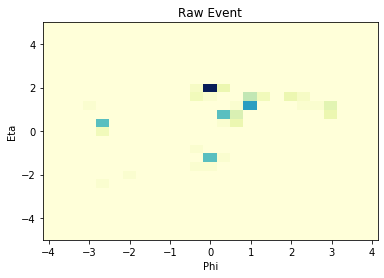

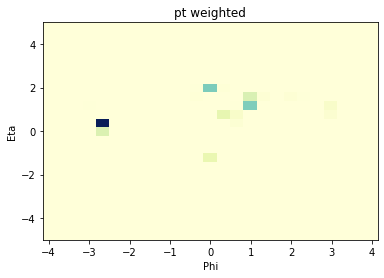

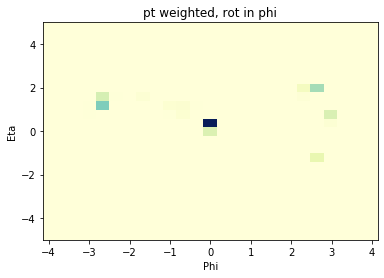

252.55770874023438 252.55770874023438 252.55770874023438 0.41146034002304077 -0.5638019442558289


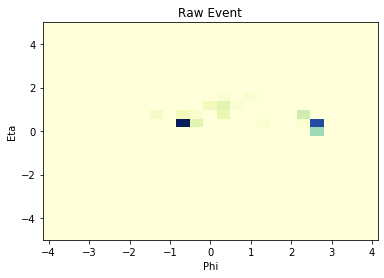

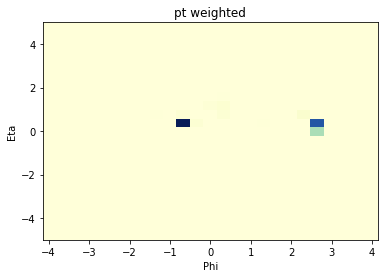

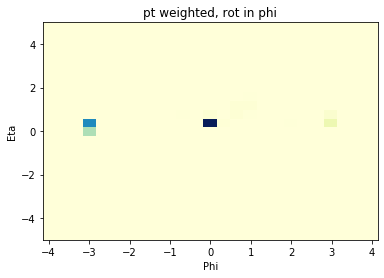

497.39813232421875 497.39813232421875 497.39813232421875 -0.8051890730857849 2.8467702865600586


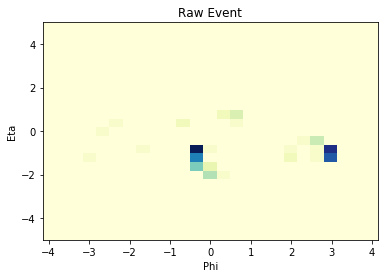

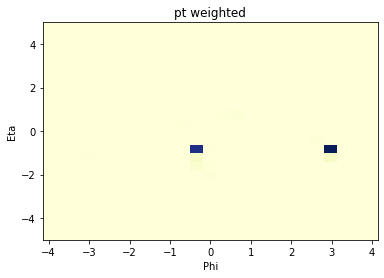

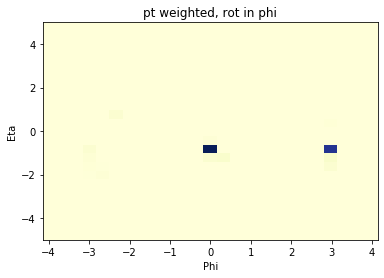

285.5962829589844 285.5962829589844 285.5962829589844 0.06891974061727524 -2.129371166229248


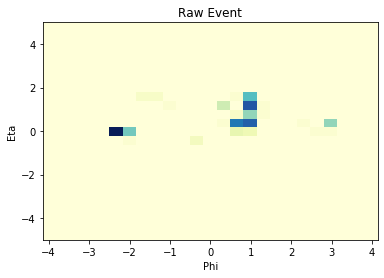

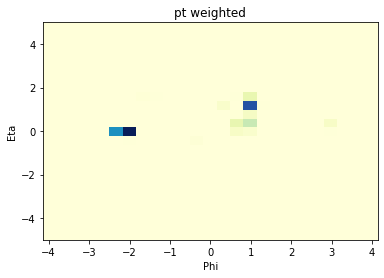

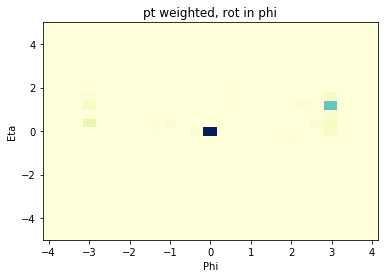

716.2669067382812 716.2669067382812 716.2669067382812 0.7971439957618713 0.3185913562774658


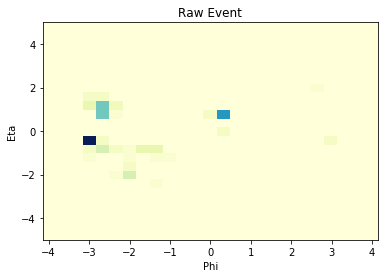

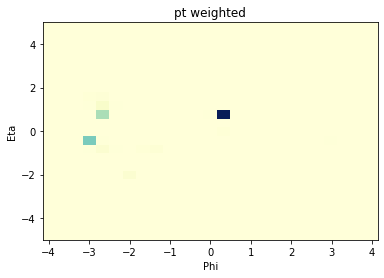

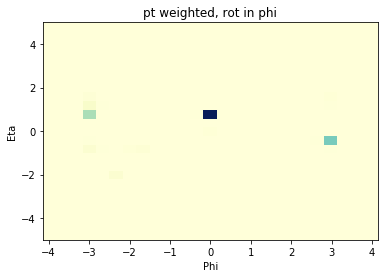

587.4020385742188 587.4020385742188 587.4020385742188 1.182598352432251 1.475293517112732


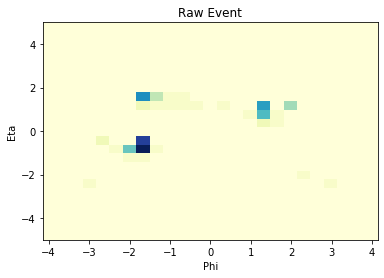

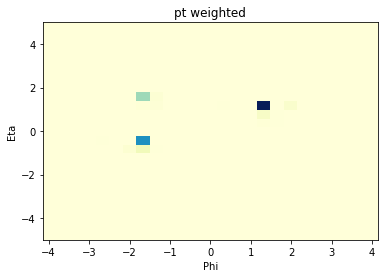

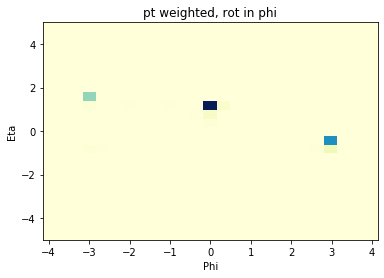

694.8456420898438 694.8456420898438 694.8456420898438 -0.28465959429740906 -0.8771829605102539


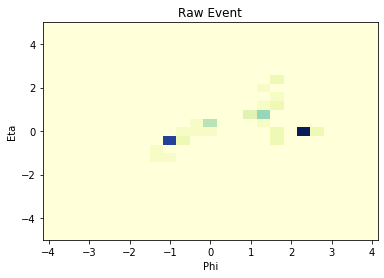

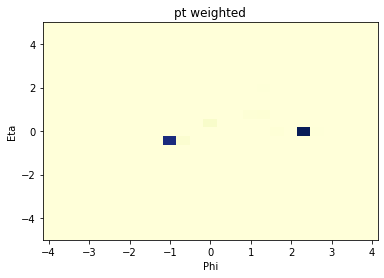

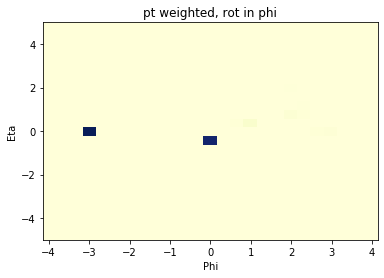

393.3050231933594 393.3050231933594 393.3050231933594 -0.2605723440647125 -0.9832208752632141


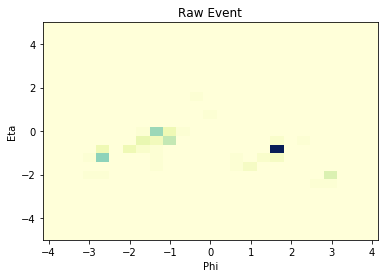

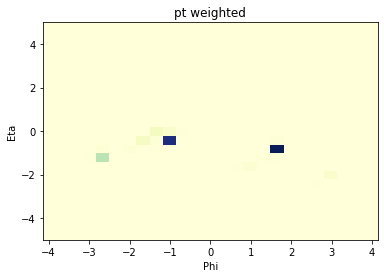

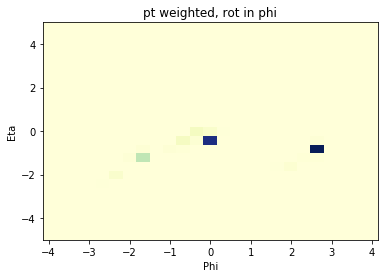

554.2276000976562 554.2276000976562 554.2276000976562 0.22918397188186646 -0.23635755479335785


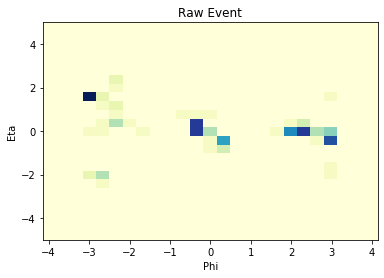

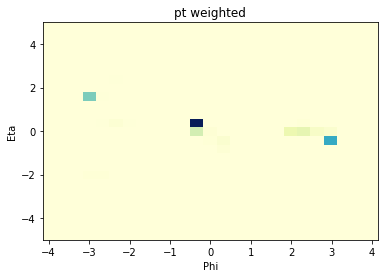

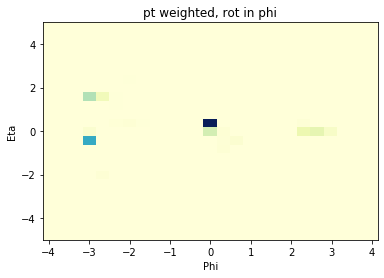

1146.9945068359375 1146.9945068359375 1146.9945068359375 -0.9522851705551147 -2.8269262313842773


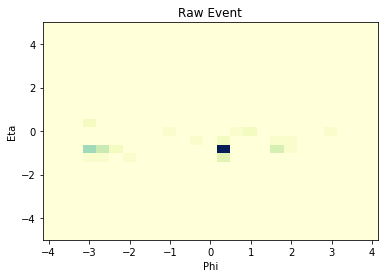

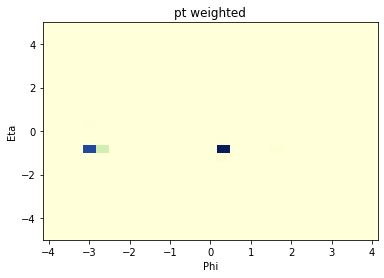

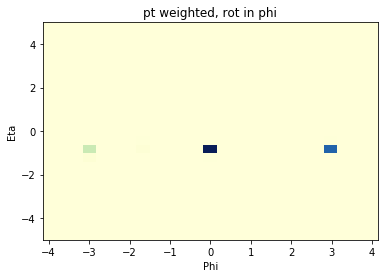

327.7366638183594 327.7366638183594 327.7366638183594 1.3857085704803467 -1.0058737993240356


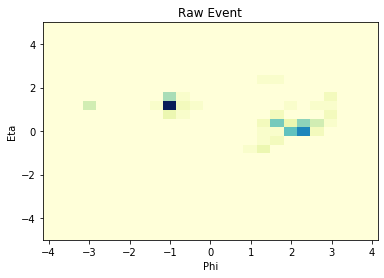

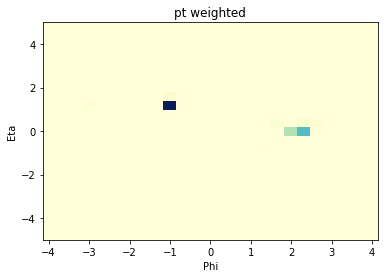

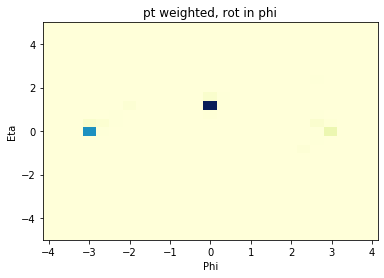

196.8775634765625 196.8775634765625 196.8775634765625 -0.17669843137264252 0.15698716044425964


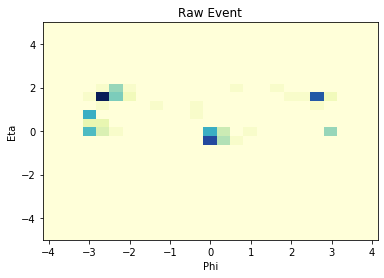

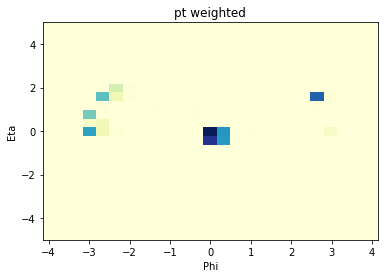

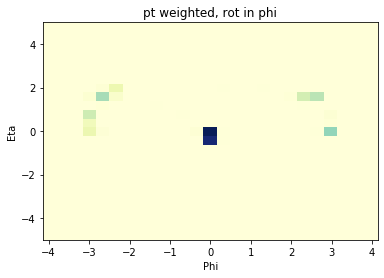

616.8617553710938 616.8617553710938 616.8617553710938 -0.17319750785827637 1.7203361988067627


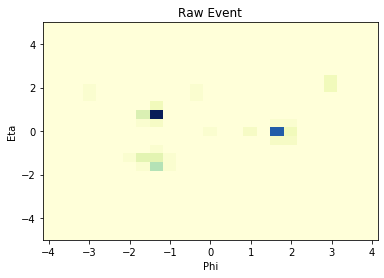

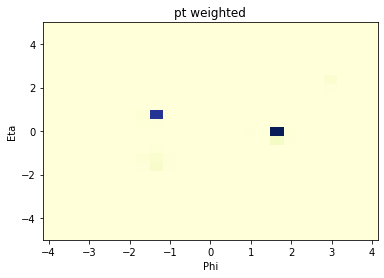

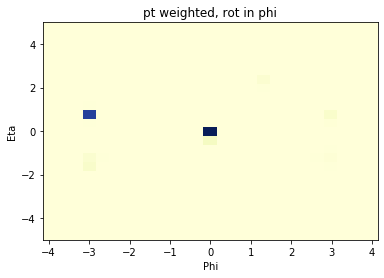

625.491455078125 625.491455078125 625.491455078125 -0.2452542930841446 3.038743257522583


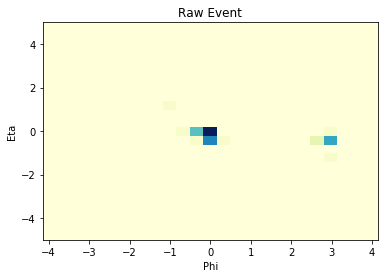

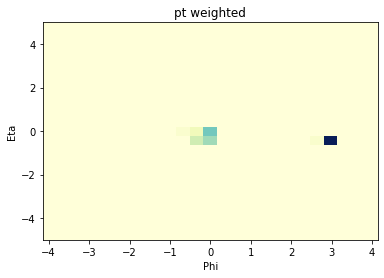

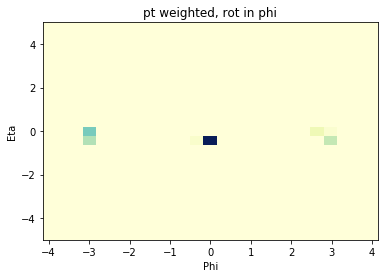

251.41558837890625 251.41558837890625 251.41558837890625 -0.16481414437294006 1.480612874031067


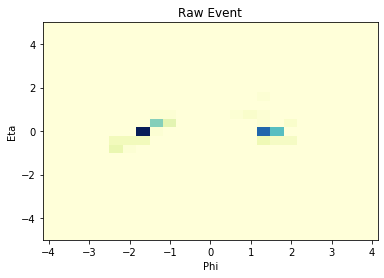

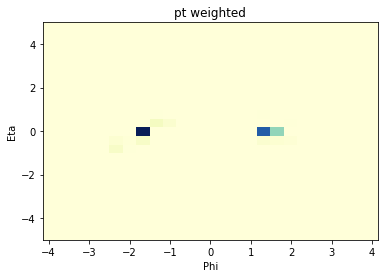

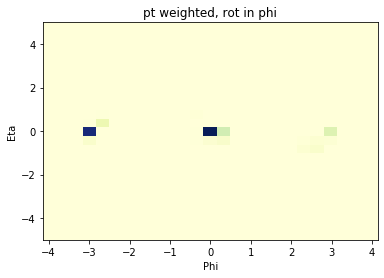

330.2690124511719 330.2690124511719 330.2690124511719 1.1613630056381226 -2.7705235481262207


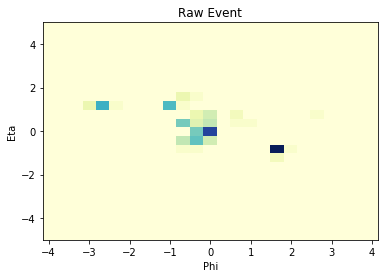

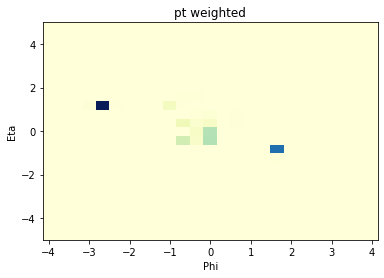

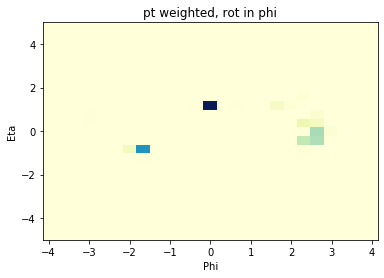

569.8797607421875 569.8797607421875 569.8797607421875 -0.12808994948863983 -0.8512922525405884


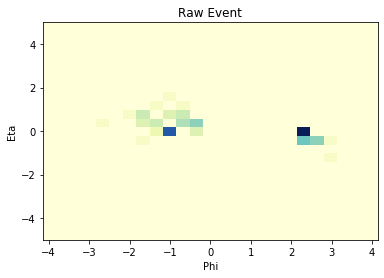

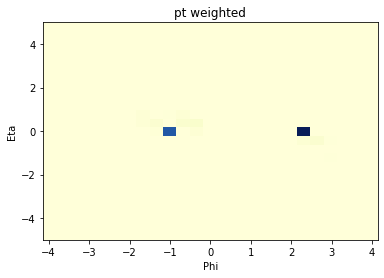

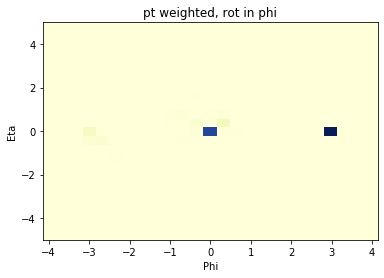

294.7197570800781 294.7197570800781 294.7197570800781 0.473289430141449 0.9060229063034058


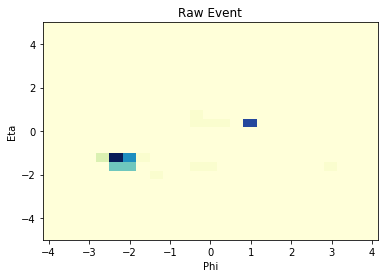

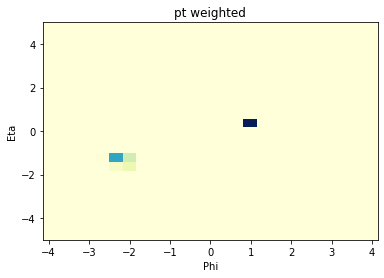

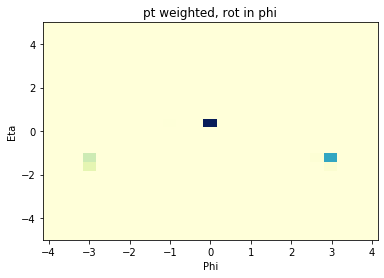

320.94622802734375 320.94622802734375 320.94622802734375 1.2275229692459106 0.9232115745544434


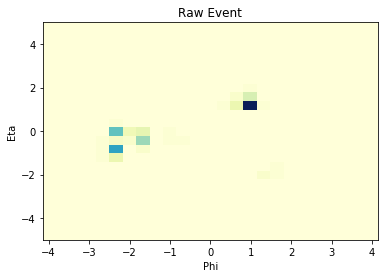

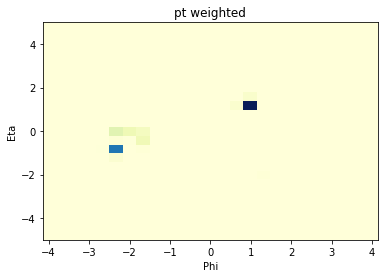

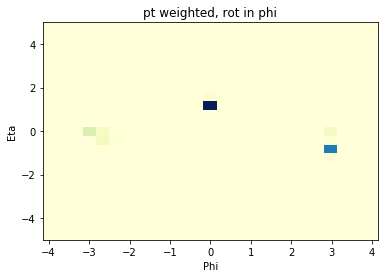

871.1630249023438 871.1630249023438 871.1630249023438 0.052126795053482056 -1.4742413759231567


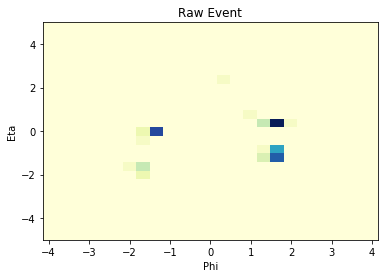

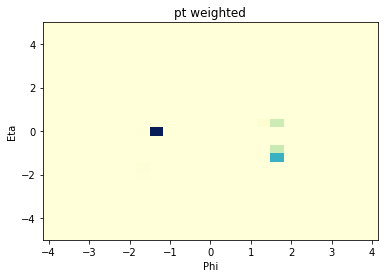

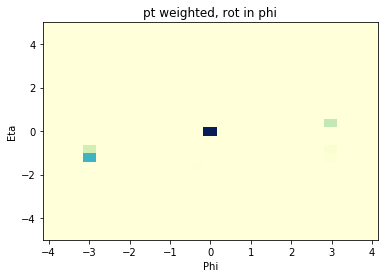

723.1995239257812 723.1995239257812 723.1995239257812 0.407236784696579 1.0064287185668945


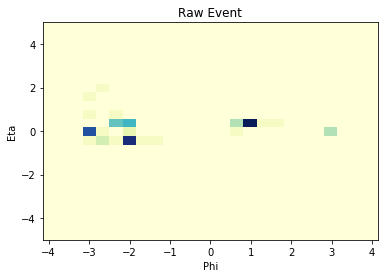

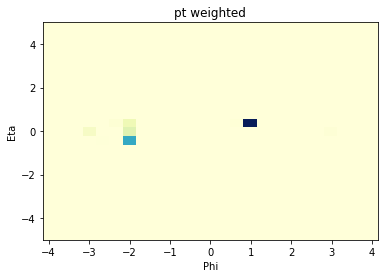

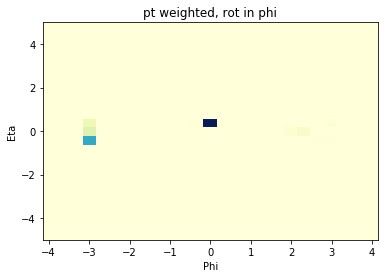

700.485595703125 700.485595703125 700.485595703125 0.823371171951294 -0.30640554428100586


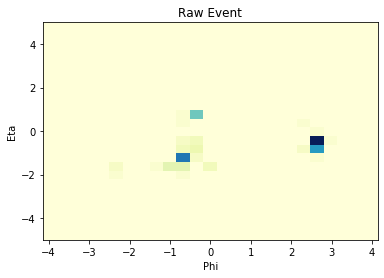

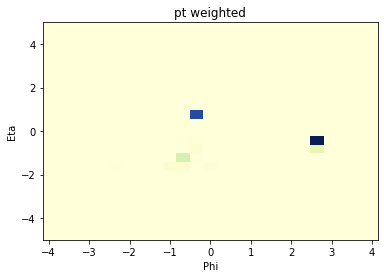

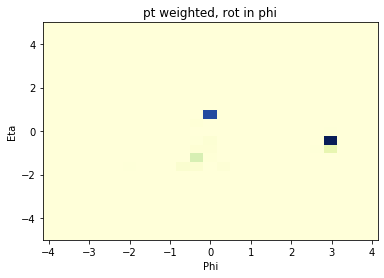

In [8]:

# *** Make some event-by-event image plots and also do translation to unified frame
allEta = []
allTheta = []
allPhi = []
allPt  = []
allPtNormed  = []
allPhiTrans  = []
allPhiRot    = []
allEtaRot    = []
allThetaRot    = []

plotOpts = dict(bins=(25, 25), range=[[-1*np.pi-1, np.pi+1],[-5.0, 5.0]], cmap=plt.cm.YlGnBu)

for event in range(0, len(newRows)):
    #if event > 1:
    #    break
    
    _pt    = [ particle[0] for particle in newRows[event] ]
    _eta   = [ particle[1] for particle in newRows[event] ]
    _theta = [ returnTheta(x) for x in _eta ]
    _phi   = [ particle[2] for particle in newRows[event] ]
    _tlv   = [ TLorentzVector.PtEtaPhiMassLorentzVector( particle[0], particle[1], particle[2], 0) for particle in newRows[event] ]
    
    _highestPtIndex = _pt.index(max(_pt))
    _hardestPhi     = _phi[_highestPtIndex]
    _hardestTheta   = returnTheta(_eta[_highestPtIndex])
    #_hardestPhi = np.pi/2
    _hardestTheta = np.pi/4

    ### rotate by phi
    _tlv_rotatedByPhi = getRotatedVectors( _tlv, _angle = _hardestPhi , _axis=[0, 0, 1] )
    _phi_rot = [ tlv.phi for tlv in _tlv_rotatedByPhi ]
    _tlv_rotatedByEta = getRotatedVectors( _tlv_rotatedByPhi, _angle = _hardestTheta , _axis=[-1, 0, 0] )
    #_tlv_rotatedByEta = _tlv_rotatedByPhi
    _eta_rot   = [ tlv.eta for tlv in _tlv_rotatedByEta ]
    _theta_rot = [ returnTheta(tlv.eta) for tlv in _tlv_rotatedByEta ]
  
    
    ###   
    _phi_trans = [ rotatePhi(p_phi, _hardestPhi) for p_phi in _phi ]
    _pt_normed = [ particle[0]/_pt[_highestPtIndex] for particle in newRows[event] ]
    
    #print(max(_pt), _pt[_highestPtIndex], _eta[_highestPtIndex], _phi[_highestPtIndex])
    print(max(_pt), _pt[_highestPtIndex], _tlv[_highestPtIndex].pt, _tlv[_highestPtIndex].eta, _tlv[_highestPtIndex].phi)
    
    
    allPt       += _pt 
    allPtNormed += _pt_normed
    allEta      += _eta 
    allEtaRot   += _eta_rot
    allTheta    += _theta 
    allThetaRot += _theta_rot
    
    allPhi      += _phi
    allPhiTrans += _phi_trans
    allPhiRot   += _phi_rot
    
    plt.hist2d( _phi, _eta, **plotOpts )
    plt.title('Raw Event')
    plt.xlabel('Phi')
    plt.ylabel('Eta')
    plt.show()
    
    plt.hist2d( _phi, _eta, weights=_pt, **plotOpts)
    plt.xlabel('Phi')
    plt.ylabel('Eta')
    plt.title('pt weighted')
    plt.show()
        
    plt.hist2d( _phi_rot, _eta, weights=_pt, **plotOpts)
    plt.title('pt weighted, rot in phi')
    plt.xlabel('Phi')
    plt.ylabel('Eta')
    plt.show()

In [162]:
#np.pi + (-2.597 - np.pi/2) + np.pi 
_testVector = np.array([0, 2, 0])
_magTestVector = np.sqrt( np.abs( _testVector.dot(_testVector) ) )
_testTheta  = np.arccos( _testVector[2] / _magTestVector )
_testEta = -1* np.log(np.tan( (_testTheta )/2) )

_newVector = np.array([0, np.sqrt(1/2), np.sqrt(1/2)])
_magNewVector = np.sqrt( np.abs( _newVector.dot(_newVector) ) )
_newTheta  = np.arccos( _newVector[2] / _magNewVector )
_newEta = -1* np.log(np.tan( ( _newTheta)/2) )

_angle = np.pi/2
_axis = [-1, 0, 0]
r = R.from_rotvec( _angle * np.array(_axis))   
_new3Vector = np.array([ _testVector[0], _testVector[1], _testVector[2] ])
_new3Vector = _new3Vector.dot( r.as_matrix() )
_mag3Vector = np.sqrt( np.abs( _new3Vector.dot(_new3Vector) ) )
_new3Theta  = np.arccos( _new3Vector[2] / _mag3Vector )
_new3Eta = -1* np.log(np.tan( ( _new3Theta)/2) )
        
print(_testTheta, _testEta, _newTheta, _newEta, _new3Theta, _new3Eta)
print(_testVector)
print(_newVector)
print(_new3Vector)

1.5707963267948966 1.1102230246251565e-16 0.7853981633974483 0.881373587019543 0.0 inf
[0 2 0]
[0.         0.70710678 0.70710678]
[0.0000000e+00 4.4408921e-16 2.0000000e+00]


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


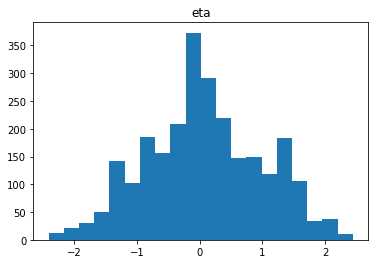

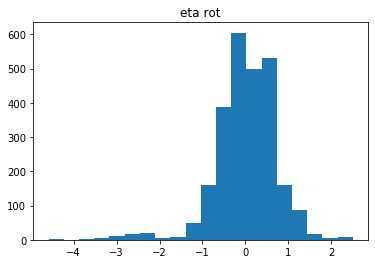

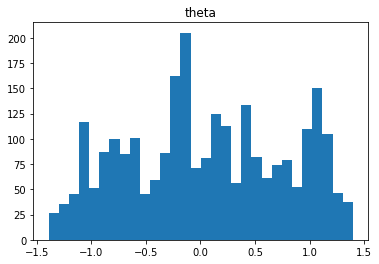

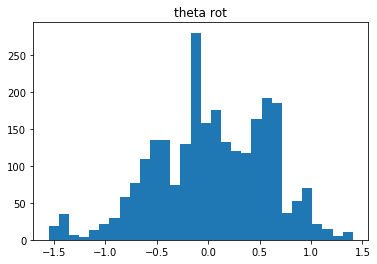

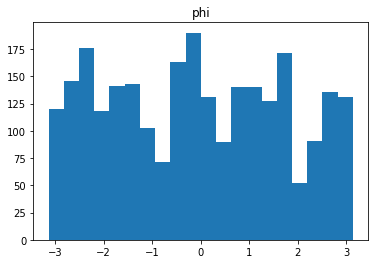

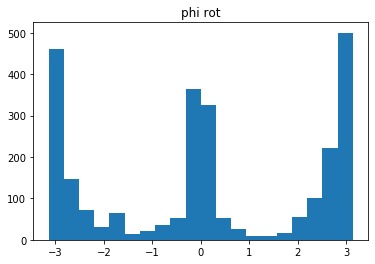

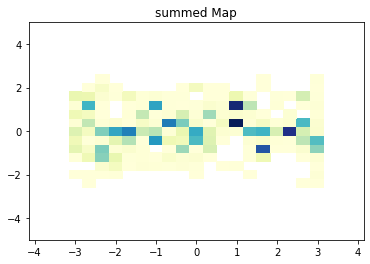

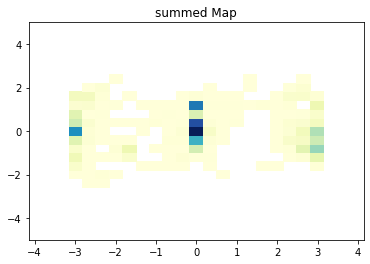

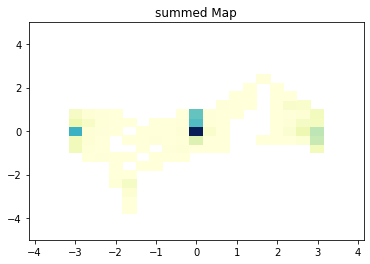

In [152]:
#plt.hist(allPt, bins=50)
#plt.title('pt')
#plt.show()
plt.hist(allEta, bins=20)
plt.title('eta')
plt.show()
plt.hist(allEtaRot, bins=20)
plt.title('eta rot')
plt.show()

plt.hist(allTheta, bins=30)
plt.title('theta')
plt.show()
plt.hist(allThetaRot, bins=30)
plt.title('theta rot')
plt.show()

plt.hist(allPhi, bins=20)
plt.title('phi')
plt.show()

plt.hist(allPhiRot, bins=20)
plt.title('phi rot')
plt.show()

plt.hist2d(allPhi, allEta, weights=allPtNormed, **plotOpts, cmin=.01)
plt.title('summed Map')
plt.show()
plt.hist2d(allPhiTrans, allEta, weights=allPtNormed, **plotOpts, cmin=.01)
plt.title('summed Map')
plt.show()
plt.hist2d(allPhiRot, allEtaRot, weights=allPtNormed, **plotOpts, cmin=.01)
plt.title('summed Map')
plt.show()

In [ ]:
eta = 1.5

In [346]:
def returnTheta( _eta ):
    #return 180     - 2*np.arctan(np.exp(-1 * _eta))*360/np.pi  # degrees
    return np.pi/2 - 2*np.arctan(np.exp(-1 * _eta))            # radians

def returnEta( _theta ):
    return -1* np.log(np.tan((np.pi/2-_theta)/2))  # radians
    
def rotateEta( _eta, _theta):
    _thetaOriginal = returnTheta(_eta)
    
    print(_thetaOriginal, _theta)
    #_newTheta = (((_thetaOriginal - _theta)+np.pi) % (2*np.pi))-np.pi
    _newTheta = (((_thetaOriginal - _theta)) % (2*np.pi))
    
    return returnEta(_newTheta) 

def rotatePhi(_phi, _rotAngle):
    return (((_phi - _rotAngle)+np.pi) % (2*np.pi))-np.pi 


theta1 = returnTheta(1.5)
theta2 = returnTheta(-0.5)
theta3 = returnTheta(0.0)
theta4 = returnTheta(2.5)
print(theta1, theta2, theta3, theta4)

eta1 = returnEta(theta1)
eta2 = returnEta(theta2)
eta3 = returnEta(theta3)
eta4 = returnEta(theta4)
print(eta1, eta2, eta3, eta4)

theta1_1 = rotateEta(0.0, np.pi)
#theta2 = theta*np.cos(theta)
print(theta1_1)

1.131728345250509 -0.48038107913372974 0.0 1.4069935689361537
1.4999999999999998 -0.5000000000000003 1.1102230246251565e-16 2.5
0.0 3.141592653589793
nan


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [293]:
returnTheta(-np.pi/2)

-1.1608753909688043

In [196]:
np.cos(0)

1.0

In [281]:
print(_tlv[6].pt, _tlv[6].energy, _tlv[6]) 

4.745270252227783 10.479161426573947 TLorentzVector(4.7453, -1.4297, -0.63138, 0)


In [285]:
_tlv[6].t

10.479161426573947

In [352]:
rotatePhi(-3*np.pi/4, np.pi/4)

-3.141592653589793

In [11]:
angle = np.pi / 1
print( np.cos(angle) + np.sin(angle), np.cos(angle) - np.sin(angle))

-0.9999999999999999 -1.0000000000000002


In [18]:
a = R.from_rotvec( [0,0, np.pi/2])
r = R.from_rotvec(np.pi/4 * np.array([0, 0, 1]))
r.as_matrix()

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [19]:
v= np.array([3, 0, 1])
vp = v.dot(r.as_matrix())
print(v.dot(r.as_matrix()), v.dot(v), vp.dot(vp))
#a.as_matrix()

[ 2.12132034 -2.12132034  1.        ] 10 10.0


In [20]:
type(np.pi/4)

float

In [27]:
np.arctan2( 0, -1 )

3.141592653589793

In [68]:
_tlv[0].phi

-1.0845133066177368

In [96]:
np.arctan2(_tlv[0].y, _tlv[0].x)

-1.0845133066177368